# 훼손 및 블러링 이미지 데이터 품질 향상 (Image Deblurring)
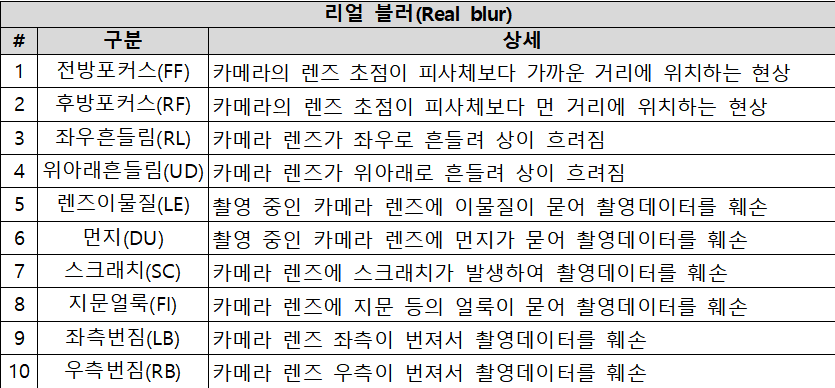

In [1]:
!pip install opencv-python==4.8.0.74

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 28.3 MB/s eta 0:00:0000:0100:01m
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


### Seed 고정

In [1]:
import torch
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)                           # Python의 random 시드 설정
    np.random.seed(seed)                        # Numpy의 random 시드 설정
    torch.manual_seed(seed)                     # PyTorch CPU 시드 설정
    torch.cuda.manual_seed(seed)                # PyTorch GPU 시드 설정
    torch.cuda.manual_seed_all(seed)            # 모든 GPU의 시드를 설정 (멀티 GPU 환경)
    
    # CuDNN의 비결정적 연산을 방지하여 재현성을 높입니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
random_state = 42

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':2,
}

## Define Model Architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

from einops import rearrange



##########################################################################
## Layer Norm

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)



##########################################################################
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x



##########################################################################
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        


    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)   
        
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)
        
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out



##########################################################################
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)

##########################################################################
##---------- Restormer -----------------------
class Restormer(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=3, 
        dim = 48,
        num_blocks = [4,6,6,8], 
        num_refinement_blocks = 4,
        heads = [1,2,4,8],
        ffn_expansion_factor = 2.66,
        bias = False,
        LayerNorm_type = 'WithBias',   ## Other option 'BiasFree'
        dual_pixel_task = False        ## True for dual-pixel defocus deblurring only. Also set inp_channels=6
    ):

        super(Restormer, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[TransformerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[TransformerBlock(dim=int(dim*2**3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])])
        
        self.up4_3 = Upsample(int(dim*2**3)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**3), int(dim*2**2), kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_refinement_blocks)])
        
        #### For Dual-Pixel Defocus Deblurring Task ####
        self.dual_pixel_task = dual_pixel_task
        if self.dual_pixel_task:
            self.skip_conv = nn.Conv2d(dim, int(dim*2**1), kernel_size=1, bias=bias)
        ###########################
            
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4) 
                        
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)

        #### For Dual-Pixel Defocus Deblurring Task ####
        if self.dual_pixel_task:
            out_dec_level1 = out_dec_level1 + self.skip_conv(inp_enc_level1)
            out_dec_level1 = self.output(out_dec_level1)
        ###########################
        else:
            out_dec_level1 = self.output(out_dec_level1) + inp_img


        return out_dec_level1

In [ ]:
fftformer_arch = fftformer()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numbers
from einops import rearrange


def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')


def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)


class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight


class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type == 'BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)


class DFFN(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):

        super(DFFN, self).__init__()

        hidden_features = int(dim * ffn_expansion_factor)

        self.patch_size = 8

        self.dim = dim
        self.project_in = nn.Conv2d(dim, hidden_features * 2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features * 2, hidden_features * 2, kernel_size=3, stride=1, padding=1,
                                groups=hidden_features * 2, bias=bias)

        self.fft = nn.Parameter(torch.ones((hidden_features * 2, 1, 1, self.patch_size, self.patch_size // 2 + 1)))
        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x_patch = rearrange(x, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        x_patch_fft = torch.fft.rfft2(x_patch.float())
        x_patch_fft = x_patch_fft * self.fft
        x_patch = torch.fft.irfft2(x_patch_fft, s=(self.patch_size, self.patch_size))
        x = rearrange(x_patch, 'b c h w patch1 patch2 -> b c (h patch1) (w patch2)', patch1=self.patch_size,
                      patch2=self.patch_size)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)

        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x


class FSAS(nn.Module):
    def __init__(self, dim, bias):
        super(FSAS, self).__init__()

        self.to_hidden = nn.Conv2d(dim, dim * 6, kernel_size=1, bias=bias)
        self.to_hidden_dw = nn.Conv2d(dim * 6, dim * 6, kernel_size=3, stride=1, padding=1, groups=dim * 6, bias=bias)

        self.project_out = nn.Conv2d(dim * 2, dim, kernel_size=1, bias=bias)

        self.norm = LayerNorm(dim * 2, LayerNorm_type='WithBias')

        self.patch_size = 8

    def forward(self, x):
        hidden = self.to_hidden(x)

        q, k, v = self.to_hidden_dw(hidden).chunk(3, dim=1)

        q_patch = rearrange(q, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        k_patch = rearrange(k, 'b c (h patch1) (w patch2) -> b c h w patch1 patch2', patch1=self.patch_size,
                            patch2=self.patch_size)
        q_fft = torch.fft.rfft2(q_patch.float())
        k_fft = torch.fft.rfft2(k_patch.float())

        out = q_fft * k_fft
        out = torch.fft.irfft2(out, s=(self.patch_size, self.patch_size))
        out = rearrange(out, 'b c h w patch1 patch2 -> b c (h patch1) (w patch2)', patch1=self.patch_size,
                        patch2=self.patch_size)

        out = self.norm(out)

        output = v * out
        output = self.project_out(output)

        return output


##########################################################################
class TransformerBlock(nn.Module):
    def __init__(self, dim, ffn_expansion_factor=2.66, bias=False, LayerNorm_type='WithBias', att=False):
        super(TransformerBlock, self).__init__()

        self.att = att
        if self.att:
            self.norm1 = LayerNorm(dim, LayerNorm_type)
            self.attn = FSAS(dim, bias)

        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = DFFN(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        if self.att:
            x = x + self.attn(self.norm1(x))

        x = x + self.ffn(self.norm2(x))

        return x


class Fuse(nn.Module):
    def __init__(self, n_feat):
        super(Fuse, self).__init__()
        self.n_feat = n_feat
        self.att_channel = TransformerBlock(dim=n_feat * 2)

        self.conv = nn.Conv2d(n_feat * 2, n_feat * 2, 1, 1, 0)
        self.conv2 = nn.Conv2d(n_feat * 2, n_feat * 2, 1, 1, 0)

    def forward(self, enc, dnc):
        x = self.conv(torch.cat((enc, dnc), dim=1))
        x = self.att_channel(x)
        x = self.conv2(x)
        e, d = torch.split(x, [self.n_feat, self.n_feat], dim=1)
        output = e + d

        return output


##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x


##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
                                  nn.Conv2d(n_feat, n_feat * 2, 3, stride=1, padding=1, bias=False))

    def forward(self, x):
        return self.body(x)


class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                  nn.Conv2d(n_feat, n_feat // 2, 3, stride=1, padding=1, bias=False))

    def forward(self, x):
        return self.body(x)


##########################################################################
##---------- FFTformer -----------------------
class fftformer(nn.Module):
    def __init__(self,
                 inp_channels=3,
                 out_channels=3,
                 dim=48,
                 num_blocks=[6, 6, 12, 8],
                 num_refinement_blocks=4,
                 ffn_expansion_factor=3,
                 bias=False,
                 ):
        super(fftformer, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[
            TransformerBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in
            range(num_blocks[0])])

        self.down1_2 = Downsample(dim)
        self.encoder_level2 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 1), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias) for i in range(num_blocks[1])])

        self.down2_3 = Downsample(int(dim * 2 ** 1))
        self.encoder_level3 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 2), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias) for i in range(num_blocks[2])])

        self.decoder_level3 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 2), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[2])])

        self.up3_2 = Upsample(int(dim * 2 ** 2))
        self.reduce_chan_level2 = nn.Conv2d(int(dim * 2 ** 2), int(dim * 2 ** 1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[
            TransformerBlock(dim=int(dim * 2 ** 1), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[1])])

        self.up2_1 = Upsample(int(dim * 2 ** 1))

        self.decoder_level1 = nn.Sequential(*[
            TransformerBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_blocks[0])])

        self.refinement = nn.Sequential(*[
            TransformerBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor,
                             bias=bias, att=True) for i in range(num_refinement_blocks)])

        self.fuse2 = Fuse(dim * 2)
        self.fuse1 = Fuse(dim)
        self.output = nn.Conv2d(int(dim), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):
        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)

        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3)

        out_dec_level3 = self.decoder_level3(out_enc_level3)

        inp_dec_level2 = self.up3_2(out_dec_level3)

        inp_dec_level2 = self.fuse2(inp_dec_level2, out_enc_level2)

        out_dec_level2 = self.decoder_level2(inp_dec_level2)

        inp_dec_level1 = self.up2_1(out_dec_level2)

        inp_dec_level1 = self.fuse1(inp_dec_level1, out_enc_level1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)

        out_dec_level1 = self.refinement(out_dec_level1)

        out_dec_level1 = self.output(out_dec_level1) + inp_img

        return out_dec_level1

In [ ]:
restormer_arch = Restormer()

## Training  method

In [4]:
import os
import random
import time
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToPILImage, ToTensor
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import CenterCrop, Resize
from sklearn.model_selection import train_test_split
from torchvision.transforms import *
from PIL import Image
from tqdm import tqdm


def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class CustomDataset(Dataset):
    def __init__(self, clean_image_paths, noisy_image_paths, transform=None):
        self.clean_image_paths = clean_image_paths  # 이미 리스트로 전달됨
        self.noisy_image_paths = noisy_image_paths  # 이미 리스트로 전달됨
        self.transform = transform
        self.center_crop = CenterCrop(1080)
        self.resize = Resize((224, 224))

        # Create a list of (noisy, clean) pairs
        self.noisy_clean_pairs = self._create_noisy_clean_pairs()

    def _create_noisy_clean_pairs(self):
        clean_to_noisy = {}
        for clean_path in self.clean_image_paths:
            clean_id = '_'.join(os.path.basename(clean_path).split('_')[:-1])
            clean_to_noisy[clean_id] = clean_path
        
        noisy_clean_pairs = []
        for noisy_path in self.noisy_image_paths:
            noisy_id = '_'.join(os.path.basename(noisy_path).split('_')[:-1])
            if noisy_id in clean_to_noisy:
                clean_path = clean_to_noisy[noisy_id]
                noisy_clean_pairs.append((noisy_path, clean_path))
            else:
                pass
        
        return noisy_clean_pairs

    def __len__(self):
        return len(self.noisy_clean_pairs)

    def __getitem__(self, index):
        noisy_image_path, clean_image_path = self.noisy_clean_pairs[index]

        noisy_image = Image.open(noisy_image_path).convert("RGB")
        clean_image = Image.open(clean_image_path).convert("RGB")
        
        # Central Crop and Resize
        noisy_image = self.center_crop(noisy_image)
        clean_image = self.center_crop(clean_image)
        noisy_image = self.resize(noisy_image)
        clean_image = self.resize(clean_image)
        
        if self.transform:
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            noisy_image = self.transform(noisy_image)

            torch.manual_seed(seed)  # Re-seed to ensure identical transform
            clean_image = self.transform(clean_image)
        
        return noisy_image, clean_image

# 각 블러 유형 리스트에 대해 데이터셋 구성 및 데이터 로더 생성 함수
def create_dataloader(noisy_image_paths, clean_image_paths, batch_size, transform, test_size=0.2):
    # 이미지 파일 경로로부터 ID 기반 딕셔너리 생성
    noisy_files_dict = {'_'.join(os.path.basename(x).split('_')[:-1]): x for x in noisy_image_paths}
    clean_files_dict = {'_'.join(os.path.basename(x).split('_')[:-1]): x for x in clean_image_paths}
    
    # ID 기준으로 noisy-clean 짝을 맞추기
    noisy_clean_pairs = [(noisy_files_dict[id], clean_files_dict[id]) for id in noisy_files_dict if id in clean_files_dict]
    if not noisy_clean_pairs:
        print("No pairs found!")
        return None, None

    noisy_files_matched, clean_files_matched = zip(*noisy_clean_pairs)

    # 데이터셋 분할 (8:2 비율)
    train_noisy, val_noisy, train_clean, val_clean = train_test_split(
        noisy_files_matched, clean_files_matched, test_size=test_size, random_state=random_state
    )

    # CustomDataset을 사용하여 학습 및 검증 데이터셋 생성
    train_dataset = CustomDataset(train_noisy, train_clean, transform=transform)
    val_dataset = CustomDataset(val_noisy, val_clean, transform=transform)

    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader    
    
def train(model, optimizer, train_loader, val_loader, scheduler, scaler, device, patience=3):
    model.to(device)
    criterion = nn.L1Loss().to(device) 
    
    best_loss = float('inf')  # 초기값을 매우 큰 수로 설정
    best_model = None
    epochs_no_improve = 0  # 개선되지 않은 epoch 수를 저장할 변수
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        
        # Training loop
        for noisy_imgs, clean_imgs in tqdm(iter(train_loader), desc=f"Epoch {epoch}/{CFG['EPOCHS']}"):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            optimizer.zero_grad()
            
            #With autocast()나 gradscaler를 사용하면 float16으로 계산하는 과정에서 왜곡이 생길 수 있다고 하니, 실험해봐야 함.
#             with autocast():
            outputs = model(noisy_imgs)
            l1_loss = criterion(outputs, clean_imgs)
            
#             scaler.scale(l1_loss).backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             scaler.step(optimizer)
#             scaler.update()
#             scheduler.step()
            l1_loss.backward()
            optimizer.step()
    
            train_loss.append(l1_loss.item() * noisy_imgs.size(0))
        
        # Validation step
        _val_loss = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        
        print(f'Epoch [{epoch}], Train Loss: [{_train_loss:.5f}] Val Loss: [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        # Check for improvement
        if _val_loss < best_loss:
            best_loss = _val_loss
            best_model = model
            epochs_no_improve = 0  # 개선되었으면 카운트 초기화
        else:
            epochs_no_improve += 1
        
        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break
    
    return best_model

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(iter(val_loader), desc="Validation"):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            pred = model(noisy_imgs)
            
            loss = criterion(pred, clean_imgs)
            
            val_loss.append(loss.item() * noisy_imgs.size(0))
        
        _val_loss = np.mean(val_loss)
    
    return _val_loss

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for noisy_imgs in tqdm(test_loader, desc="Inference"):
            noisy_imgs = noisy_imgs.to(device).float()
            pred = model(noisy_imgs)
            
            preds.append(pred.detach().cpu())
    
    preds = torch.cat(preds).numpy()

    return preds

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_df(model, train_loader, val_loader):
    optimizer = optim.AdamW(model.parameters(), lr=CFG["LEARNING_RATE"], weight_decay=1e-4)
    criterion = nn.L1Loss()
    scaler = GradScaler()
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["EPOCHS"])

    infer_model = train(model, optimizer, train_loader, val_loader, scheduler, scaler, device)
    
    return infer_model

In [5]:
import os
from glob import glob

#데이터셋 경로
base_dir = './data/Training'
noisy_image_paths = os.path.join(base_dir, 'noisy')
clean_image_paths = os.path.join(base_dir, 'clean')

clean_files = [os.path.join(clean_image_paths, x) for x in os.listdir(clean_image_paths)]

# 각 유형별로 리스트 초기화
ff_rf_paths = []
rl_ud_paths = []
lb_rb_paths = []
other_blur_paths = []

# 이미지 파일 리스트 생성
all_image_paths = glob(os.path.join(noisy_image_paths, '*.jpg'))

# 파일 경로 리스트 분류
for image_path in all_image_paths:
    filename = os.path.basename(image_path)
    
    # 블러 유형 추출 (FI 등)
    blur_type = filename.split('_')[-1][:2]
    
    if blur_type in ['FF', 'RF']:
        ff_rf_paths.append(image_path)
    elif blur_type in ['RL', 'UD']:
        rl_ud_paths.append(image_path)
    elif blur_type in ['LB', 'RB']:
        lb_rb_paths.append(image_path)
    else:
        other_blur_paths.append(image_path)

# 결과 출력
print("FF, RF 블러 유형 이미지 파일 경로 리스트:", len(ff_rf_paths))
print("RL, UD 블러 유형 이미지 파일 경로 리스트:", len(rl_ud_paths))
print("LB, RB 블러 유형 이미지 파일 경로 리스트:", len(lb_rb_paths))
print("기타 블러 유형 이미지 파일 경로 리스트:", len(other_blur_paths))

# 데이터셋 로드 및 전처리 
train_transform = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
#     RandomRotation(degrees=10),
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #official github에서 안 써서 쓰면 안됨.
])

# 예시로 FF, RF, RL, UD, 기타 유형별 데이터 로더 생성
ff_rf_train_loader, ff_rf_val_loader = create_dataloader(ff_rf_paths, clean_files, CFG["BATCH_SIZE"], train_transform)
rl_ud_train_loader, rl_ud_val_loader = create_dataloader(rl_ud_paths, clean_files, CFG["BATCH_SIZE"], train_transform)
lb_rb_train_loader, lb_rb_val_loader = create_dataloader(lb_rb_paths, clean_files, CFG["BATCH_SIZE"], train_transform)
other_blur_train_loader, other_blur_val_loader = create_dataloader(other_blur_paths, clean_files, CFG["BATCH_SIZE"], train_transform)

# 예시 출력
print("FF, RF 블러 유형 학습/검증 데이터 로더:", len(ff_rf_train_loader), len(ff_rf_val_loader))
print("RL, UD 블러 유형 학습/검증 데이터 로더:", len(rl_ud_train_loader), len(rl_ud_val_loader))
print("LB, RB 블러 유형 학습/검증 데이터 로더:", len(lb_rb_train_loader), len(lb_rb_val_loader))
print("기타 블러 유형 학습/검증 데이터 로더:", len(other_blur_train_loader), len(other_blur_val_loader))

FF, RF 블러 유형 이미지 파일 경로 리스트: 3653
RL, UD 블러 유형 이미지 파일 경로 리스트: 3569
LB, RB 블러 유형 이미지 파일 경로 리스트: 3367
기타 블러 유형 이미지 파일 경로 리스트: 6829
FF, RF 블러 유형 학습/검증 데이터 로더: 700 175
RL, UD 블러 유형 학습/검증 데이터 로더: 680 171
LB, RB 블러 유형 학습/검증 데이터 로더: 650 163
기타 블러 유형 학습/검증 데이터 로더: 1303 326


In [ ]:
lb_rb_model = fftformer_arch.to(device)
lb_rb_model.load_state_dict(torch.load('./fftformer_GoPro.pth')) #GoPro_pretrained 모델

lb_rb_model = train_df(lb_rb_model, lb_rb_train_loader, lb_rb_val_loader)
#Epoch [5], Train Loss: [0.33701] Val Loss: [0.30922] autocast 적용 o

Epoch 1/20: 100% 650/650 [13:47<00:00,  1.27s/it]
Validation: 100% 163/163 [00:59<00:00,  2.72it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1], Train Loss: [0.35467] Val Loss: [0.30619]


Epoch 2/20: 100% 650/650 [13:43<00:00,  1.27s/it]
Validation: 100% 163/163 [00:59<00:00,  2.73it/s]


Epoch [2], Train Loss: [0.29086] Val Loss: [0.28700]


Epoch 3/20: 100% 650/650 [13:46<00:00,  1.27s/it]
Validation: 100% 163/163 [00:59<00:00,  2.73it/s]


Epoch [3], Train Loss: [0.28780] Val Loss: [0.27334]


Epoch 4/20: 100% 650/650 [13:39<00:00,  1.26s/it]
Validation: 100% 163/163 [00:59<00:00,  2.74it/s]


Epoch [4], Train Loss: [154.20852] Val Loss: [0.79057]


Epoch 5/20: 100% 647/650 [13:33<00:03,  1.30s/it]

In [ ]:
torch.save(lb_rb_model.state_dict(), 'lb_rb_fftformer_GoPro_1080.pth')

In [ ]:
other_blur_model = fftformer_arch.to(device)
other_blur_model.load_state_dict(torch.load('./fftformer_GoPro.pth')) #GoPro_pretrained 모델

# other_blur_model = Restormer().to(device)
# other_blur_restormer_weight = torch.load('./single_image_defocus_deblurring.pth')
# other_blur_model.load_state_dict(other_blur_restormer_weight['params'])

other_blur_model = train_df(other_blur_model, other_blur_train_loader, other_blur_val_loader)

In [ ]:
torch.save(other_blur_model.state_dict(), 'other_blur4_fftformer_GoPro_1080.pth')

In [ ]:
ff_rf_model = restormer_arch.to(device)
ff_rf_restormer_weight = torch.load('./single_image_defocus_deblurring.pth')
ff_rf_model.load_state_dict(ff_rf_restormer_weight['params'])

ff_rf_model = train_df(ff_rf_model, ff_rf_train_loader, ff_rf_val_loader)

Epoch 1/10:  52% 367/700 [03:07<02:43,  2.03it/s]

In [ ]:
torch.save(ff_rf_model.state_dict(), 'ff_rf_10epoch.pth')

In [ ]:
# FFtformer 모델 인스턴스 생성 및 GPU로 이동
rl_ud_model = fftformer_arch.to(device)
rl_ud_model.load_state_dict(torch.load('./fftformer_GoPro.pth')) #GoPro_pretrained 모델

rl_ud_model = train_df(rl_ud_model, rl_ud_train_loader, rl_ud_val_loader)

In [ ]:
torch.save(rl_ud_model.state_dict(), 'rl_ud_10epoch.pth')

### Validation 성능 시각화
psnr 및 ssim 코드 수정 필요할 듯 (실행 안 해봄)

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

class CustomDatasetVal(Dataset):
    def __init__(self, clean_image_paths, noisy_image_paths, transform=None):
        self.clean_image_paths = clean_image_paths#[os.path.join(clean_image_paths, x) for x in os.listdir(clean_image_paths)]
        self.noisy_image_paths = noisy_image_paths#[os.path.join(noisy_image_paths, x) for x in os.listdir(noisy_image_paths)]
        self.transform = transform
        self.center_crop = CenterCrop(1080)
        self.resize = Resize((224, 224))

        # Create a list of (noisy, clean) pairs
        self.noisy_clean_pairs = self._create_noisy_clean_pairs()

    def _create_noisy_clean_pairs(self):
        clean_to_noisy = {}
        for clean_path in self.clean_image_paths:
            clean_id = '_'.join(os.path.basename(clean_path).split('_')[:-1])
            clean_to_noisy[clean_id] = clean_path
        
        noisy_clean_pairs = []
        for noisy_path in self.noisy_image_paths:
            noisy_id = '_'.join(os.path.basename(noisy_path).split('_')[:-1])
            if noisy_id in clean_to_noisy:
                clean_path = clean_to_noisy[noisy_id]
                noisy_clean_pairs.append((noisy_path, clean_path))
            else:
                pass
        
        return noisy_clean_pairs

    def __len__(self):
        return len(self.noisy_clean_pairs)

    def __getitem__(self, index):
        noisy_image_path, clean_image_path = self.noisy_clean_pairs[index]

        noisy_image = Image.open(noisy_image_path).convert("RGB")
        clean_image = Image.open(clean_image_path).convert("RGB")
        
        # Central Crop and Resize
        noisy_image = self.center_crop(noisy_image)
        clean_image = self.center_crop(clean_image)
        noisy_image = self.resize(noisy_image)
        clean_image = self.resize(clean_image)
        
        if self.transform:
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            noisy_image = self.transform(noisy_image)

            torch.manual_seed(seed)  # Re-seed to ensure identical transform
            clean_image = self.transform(clean_image)
        
        return noisy_image, clean_image
    
# 데이터셋 로드 및 전처리 
val_transform = Compose([
#     RandomHorizontalFlip(),
#     RandomVerticalFlip(),
#     RandomRotation(degrees=10),
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #official github에서 안 써서 쓰면 안됨.
])
    
#데이터셋 경로
base_dir = './data/Validation'
validation_noisy_image_paths = os.path.join(base_dir, 'noisy')
validation_clean_image_paths = os.path.join(base_dir, 'clean')

validation_clean_files = [os.path.join(validation_clean_image_paths, x) for x in os.listdir(validation_clean_image_paths)]

# 각 유형별로 리스트 초기화
validation_ff_rf_paths = []
validation_rl_ud_paths = []
validation_lb_rb_paths = []
validation_other_blur_paths = []

# 이미지 파일 리스트 생성
validation_all_image_paths = glob(os.path.join(validation_noisy_image_paths, '*.jpg'))

# 파일 경로 리스트 분류
for image_path in validation_all_image_paths:
    filename = os.path.basename(image_path)
    
    # 블러 유형 추출 (FI 등)
    blur_type = filename.split('_')[-1][:2]
    
    if blur_type in ['FF', 'RF']:
        validation_ff_rf_paths.append(image_path)
    elif blur_type in ['RL', 'UD']:
        validation_rl_ud_paths.append(image_path)
    elif blur_type in ['LB', 'RB']:
        validation_lb_rb_paths.append(image_path)
    else:
        validation_other_blur_paths.append(image_path)

# 결과 출력
print("FF, RF 블러 유형 이미지 파일 경로 리스트:", len(validation_ff_rf_paths))
print("RL, UD 블러 유형 이미지 파일 경로 리스트:", len(validation_rl_ud_paths))
print("LB, RB 블러 유형 이미지 파일 경로 리스트:", len(validation_lb_rb_paths))
print("기타 블러 유형 이미지 파일 경로 리스트:", len(validation_other_blur_paths))

validation_ff_rf_dataset = CustomDatasetVal(validation_clean_files, validation_ff_rf_paths, transform=val_transform)
validation_ff_rf_loader = DataLoader(validation_ff_rf_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
validation_rl_ud_dataset = CustomDatasetVal(validation_clean_files, validation_rl_ud_paths, transform=val_transform)
validation_rl_ud_loader = DataLoader(validation_rl_ud_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
validation_lb_rb_dataset = CustomDatasetVal(validation_clean_files, validation_lb_rb_paths, transform=val_transform)
validation_lb_rb_loader = DataLoader(validation_lb_rb_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
validation_other_blur_dataset = CustomDatasetVal(validation_clean_files, validation_other_blur_paths, transform=val_transform)
validation_other_blur_loader = DataLoader(validation_other_blur_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
    
ff_rf_model = restormer_arch.to(device)
ff_rf_model.load_state_dict(torch.load('./ff_rf_10epoch.pth'))
rl_ud_model = fftformer_arch.to(device)
rl_ud_model.load_state_dict(torch.load('./rl_ud_10epoch.pth'))
lb_rb_model = fftformer_arch.to(device)
lb_rb_model.load_state_dict(torch.load('./lb_rb_fftformer_GoPro_1080'))
other_blur_model = fftformer_arch.to(device)
other_blur_model.load_state_dict(torch.load('./other_blur_fftformer.pth'))
    
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_value = 1. if img1.max() <= 1 else 255.
    psnr = 20 * torch.log10(max_value / torch.sqrt(mse))
    return psnr.item()

def calculate_ssim(img1, img2):
    """Calculate SSIM (Structural Similarity Index) between two images."""
    # Convert tensors to numpy arrays and remove extra batch dimension
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    # Calculate SSIM between the two images
    ssim_value = ssim(img1_np, img2_np, multichannel=True, data_range=img2_np.max() - img2_np.min())
    return ssim_value

def validate_metrics(ff_rf_model, rl_ud_model, lb_rb_model, other_blur_model, validation_ff_rf_loader, validation_rl_ud_loader, validation_lb_rb_loader, validation_other_blur_loader, device):
    ff_rf_model.eval()
    rl_ud_model.eval()
    lb_rb_model.eval()
    other_blur_model.eval()
    psnr_values = []
    ssim_values = []
    
    with torch.no_grad():
        for noisy_imgs, clean_imgs in validation_ff_rf_loader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            pred_imgs = ff_rf_model(noisy_imgs)
            
            for i in range(len(pred_imgs)):
                psnr_value = calculate_psnr(pred_imgs[i], clean_imgs[i])
                ssim_value = calculate_ssim(pred_imgs[i], clean_imgs[i])
                
                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)
                
                
        for noisy_imgs, clean_imgs in validation_rl_ud_loader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            pred_imgs = rl_ud_model(noisy_imgs)
            
            for i in range(len(pred_imgs)):                
                psnr_value = calculate_psnr(pred_imgs[i], clean_imgs[i])
                ssim_value = calculate_ssim(pred_imgs[i], clean_imgs[i])
                
                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)
        
        for noisy_imgs, clean_imgs in validation_lb_rb_loader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            pred_imgs = lb_rb_model(noisy_imgs)
            
            for i in range(len(pred_imgs)):                
                psnr_value = calculate_psnr(pred_imgs[i], clean_imgs[i])
                ssim_value = calculate_ssim(pred_imgs[i], clean_imgs[i])
                
                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)
                
        for noisy_imgs, clean_imgs in validation_other_blur_loader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            
            pred_imgs = other_blur_model(noisy_imgs)
            
            for i in range(len(pred_imgs)):                
                psnr_value = calculate_psnr(pred_imgs[i], clean_imgs[i])
                ssim_value = calculate_ssim(pred_imgs[i], clean_imgs[i])
                
                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

# Visualize predictions and calculate PSNR
avg_psnr, avg_ssim = validate_metrics(ff_rf_model, rl_ud_model, other_blur_model, validation_ff_rf_loader, validation_rl_ud_loader, validation_other_blur_loader, device)

In [ ]:
###### 모델 테스트(추론) ######
import os
from os import listdir
from os.path import join, splitext
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# 데이터셋 경로
noisy_data_path = './open/test/input'
output_path = './open/test/submission'

# 각 유형별로 리스트 초기화
test_ff_rf_paths = []
test_rl_ud_paths = []
test_lb_rb_paths = []
test_other_blur_paths = []

# 이미지 파일 리스트 생성
test_all_image_paths = glob(os.path.join(noisy_data_path, '*.jpg'))

# 파일 경로 리스트 분류
for image_path in test_all_image_paths:
    filename = os.path.basename(image_path)
    
    # 블러 유형 추출 (FI 등)
    blur_type = filename.split('_')[-1][:2]
    
    if blur_type in ['FF', 'RF']:
        test_ff_rf_paths.append(image_path)
    elif blur_type in ['RL', 'UD']:
        test_rl_ud_paths.append(image_path)
    elif blur_type in ['LB', 'RB']:
        test_lb_rb_paths.append(image_path)
    else:
        test_other_blur_paths.append(image_path)

# 결과 출력
print("FF, RF 블러 유형 이미지 파일 경로 리스트:", len(test_ff_rf_paths))
print("RL, UD 블러 유형 이미지 파일 경로 리스트:", len(test_rl_ud_paths))
print("LB, RB 블러 유형 이미지 파일 경로 리스트:", len(test_lb_rb_paths))
print("기타 블러 유형 이미지 파일 경로 리스트:", len(test_other_blur_paths))


if not os.path.exists(output_path):
    os.makedirs(output_path)

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = noisy_image_paths #[join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        # Convert numpy array to PIL image
        if isinstance(noisy_image, np.ndarray):
            noisy_image = Image.fromarray(noisy_image)

        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path

test_transform = Compose([
    ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) official github에서 안 써서 쓰면 안됨.
])

test_ff_rf_dataset = CustomDatasetTest(test_ff_rf_paths, transform=test_transform)
test_ff_rf_loader = DataLoader(test_ff_rf_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
test_rl_ud_dataset = CustomDatasetTest(test_rl_ud_paths, transform=test_transform)
test_rl_ud_loader = DataLoader(test_rl_ud_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
test_lb_rb_dataset = CustomDatasetTest(test_lb_rb_paths, transform=test_transform)
test_lb_rb_loader = DataLoader(test_lb_rb_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)   
test_other_blur_dataset = CustomDatasetTest(test_other_blur_paths, transform=test_transform)
test_other_blur_loader = DataLoader(test_other_blur_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)    
    
ff_rf_model = restormer_arch.to(device)
ff_rf_model.load_state_dict(torch.load('./ff_rf_10epoch.pth'))
rl_ud_model = fftformer_arch.to(device)
rl_ud_model.load_state_dict(torch.load('./rl_ud_10epoch.pth'))
lb_rb_model = fftformer_arch.to(device)
lb_rb_model.load_state_dict(torch.load('./lb_rb_fftformer_GoPro_1080'))
other_blur_model = fftformer_arch.to(device)
other_blur_model.load_state_dict(torch.load('./other_blur_fftformer.pth'))

# 이미지 denoising 및 저장
for noisy_image, noisy_image_path in test_ff_rf_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = ff_rf_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.png'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_rl_ud_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = rl_ud_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.png'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_lb_rb_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = lb_rb_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.png'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

for noisy_image, noisy_image_path in test_other_blur_loader:
    noisy_image = noisy_image.to(device)
    denoised_image = other_blur_model(noisy_image)
    
    # denoised_image를 CPU로 이동하여 이미지 저장
    denoised_image = denoised_image.cpu().squeeze(0)
    denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    denoised_image = transforms.ToPILImage()(denoised_image)

    # Save denoised image
    output_filename = noisy_image_path[0]
    denoised_filename = output_path + '/' + output_filename.split('/')[-1][:-4] + '.jpg'
    denoised_image.save(denoised_filename) 
    
    print(f'Saved denoised image: {denoised_filename}')

In [ ]:
def zip_folder(folder_path, output_zip):
    shutil.make_archive(output_zip, 'zip', folder_path)
    print(f"Created {output_zip}.zip successfully.")

zip_folder(output_path, './submission')